## Aim: Understand distribution of samples in training set (and subsequently in neighbourhoods of latent space)


In [2]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

<module 'data_util' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [50]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader
from debug_util import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from typing import Union, List, Dict
from tqdm import tqdm
import ipywidgets as widgets
import torch.nn.functional as F
torch.manual_seed(42)
torch.set_grad_enabled(False)

SIMILARITY_THRESHOLD = 1e-3

## 1. Check distribution of samples around a single sample (in y space)

- Take single sample from training set and compare the other samples to it (in y)
- Repeat for multiple samples to be more robust
- Using dataloaders from wandb run (easiest for now)

In [4]:
from data_util import create_dataloader
from util import load_config
datapath = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/data'
name = 'dataset_241204_2'

cfg = load_config('../model/config.yaml', fallback_cfg_path='../model/config.yaml')

train_loader, valid_loader, info = create_dataloader(datapath, name, cfg, random_seed=0, shuffle_train=False, value_transform=lambda x: x)  # Using datasets with data already normalised
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

### 1.1 Compare target expression graph to rest of training set

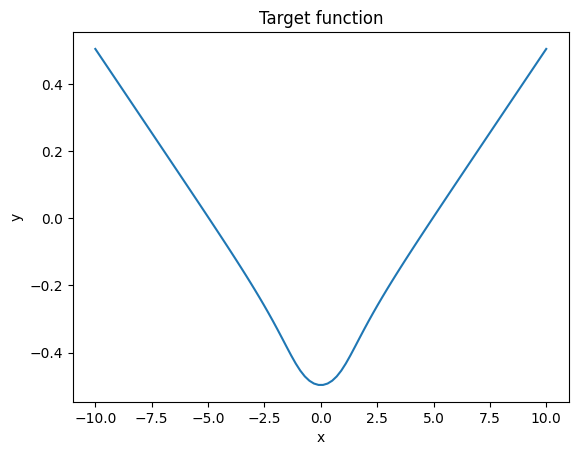

In [89]:
target_idx = 0
data_loader = train_loader  # FIXME: Only works with train_loader currently...
values_target = data_from_loader(data_loader, 'values', idx=target_idx)  

plt.plot(val_x.squeeze(), values_target.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [90]:
# Calculate MSE to target for all samples in training set

N = 2**21
BATCH_SIZE = 2**16
data_loader = train_loader

N = (min(len(data_loader.dataset), N) // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size
dist_y = torch.ones(N)
for i, values in tqdm(enumerate(data_from_loader(data_loader, 'values', batch_size=BATCH_SIZE, max_length=N)), total=N//BATCH_SIZE):
    assert values.isnan().sum() == 0, 'NaN values in dataset'
    dist_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.mean((values - values_target)**2, dim=1)  # MSE

mse_sorted = pd.Series(dist_y).sort_values()

100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


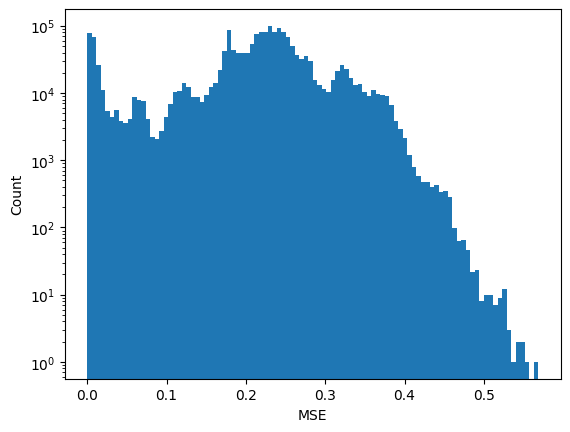

In [91]:
# Plot distribution of MSEs
plt.hist(dist_y.detach().numpy(), bins=100)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.yscale('log')
plt.show()


In [92]:
# Plot sample with a specific MSE to target (to get an idea for meaning of magnitude of MSE)

mse_wanted = widgets.FloatLogSlider(
    value=3e-5,
    min=-7,
    max=np.log10(mse_sorted.iloc[-1]),
    step=0.1,
    base=10,
    description='MSE Target:',
    continuous_update=False
)

max_mse = widgets.FloatLogSlider(
    value=1e-3, 
    min=-7,
    max=np.log10(mse_sorted.iloc[-1]),
    step=0.1,
    base=10,
    description='Max MSE:',
    continuous_update=False
)

def update_plot(mse_target, mse_max):
    idx = (pd.Series(dist_y) - mse_target).abs().idxmin()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left subplot - histogram
    counts, bins = np.histogram(dist_y.detach().numpy(), bins=100, range=(0, mse_max))
    ax1.bar(bins[:-1], counts, width=np.diff(bins), align='edge')
    ax1.axvline(x=mse_target, color='r', linestyle='--')
    ax1.set_yscale('log')
    ax1.set_xlabel('MSE')
    ax1.set_ylabel('Count')
    
    # Right subplot - function comparison
    ax2.plot(val_x.squeeze(), values_target.squeeze().detach().numpy(), label='Target', color='r')
    ax2.plot(val_x.squeeze(), data_from_loader(data_loader, 'values', idx=idx).squeeze().detach().numpy(), 
             label=f'MSE: {dist_y.detach().numpy()[idx]:.2e}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

widgets.interactive(update_plot, 
                   mse_target=mse_wanted,
                   mse_max=max_mse)

interactive(children=(FloatLogSlider(value=3e-05, continuous_update=False, description='MSE Target:', max=-0.2…

### 1.2 Calculate number of similar expressions in training set

In [23]:
# Calculate number of similar samples for a couple of examples
# Compare similarity of n targets to m samples

n, m = 512, int(1e6)
BATCH_SIZE = 4
n = (n // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size

print(f'Memory used: {BATCH_SIZE*m*100/2e9:.2f} GB')
print(f'Using {m/len(train_loader.dataset):.2f} of dataset')
assert BATCH_SIZE*m*100 < 4e9, 'Memory limit exceeded (limit is 4GB)'
  
values_samples = data_from_loader(train_loader, 'values', max_length=m)

similar_count = torch.empty(n)
for i, values_target in tqdm(enumerate(data_from_loader(train_loader, 'values', batch_size=BATCH_SIZE, max_length=n)), total=n//BATCH_SIZE, desc='Calculating similarity scores'):
    # Calculate MSE between each target and sample
    # Reshape to allow broadcasting: (n,points,1) - (m,1,points) -> (n,m)
    mse = torch.mean(
        (values_target.unsqueeze(1) - values_samples.unsqueeze(0))**2, 
        dim=2
    )
    similar_count[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = (mse < SIMILARITY_THRESHOLD).sum(dim=1)

Memory used: 0.20 GB
Using 0.54 of dataset


Calculating similarity scores: 100%|██████████| 128/128 [00:31<00:00,  4.07it/s]


/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_22660/3465354401.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hist, bins = np.histogram(similar_count.numpy(), bins=np.logspace(np.log10(similar_count.min()), np.log10(similar_count.max()), 40))


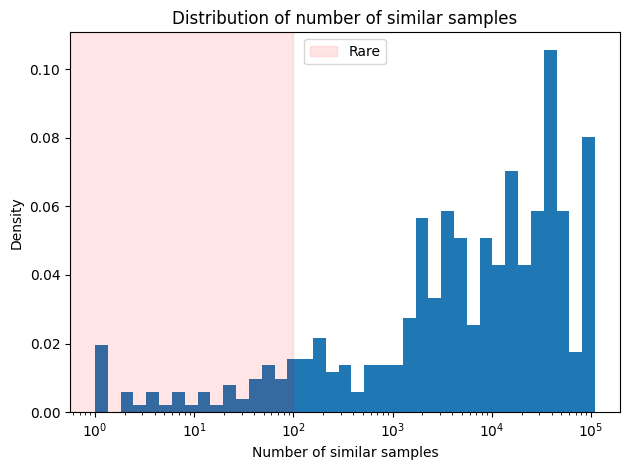

In [39]:
hist, bins = np.histogram(similar_count.numpy(), bins=np.logspace(np.log10(similar_count.min()), np.log10(similar_count.max()), 40))
hist = hist / hist.sum()

plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
plt.axvspan(xmin=0, xmax=100, color='r', alpha=0.1, label='Rare')
plt.title('Distribution of number of similar samples')
plt.xscale('log')
plt.xlabel('Number of similar samples')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Check distribution of training samples in latent space

(- will later do this for valid/random samples)
- Use different distance metrics: L2 and dot product, cosine similarity (currently using dot product for contrastive loss)

1. Plot distribution of z-dist for for different y-dist (MSE) (e.g. all within +-1e-3)
2. Plot distribution of z-dist for all samples with y-dist < threshold

3. Having defined that the expressions below threshold are the ones we are interested in, check how many communities there are. Use some spatial community detection in z using only expressions below threshold.

- For all points above, be careful as there might be large differences between target samples. Might want to repeat for multiple targets.

In [41]:
# Load model and dataset
model, cfg = load_wandb_model(run='n3gnm11h', name='last.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../model/config.yaml')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Imported model from run "n3gnm11h".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 8.9 M  | eval
1 | decoder       | Decoder      | 6.6 M  | eval
2 | value_decoder | ValueDecoder | 6.4 M  | eval
------------------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.677    Total estimated model params size (MB)
0         Modules in train mode
101       Modules in eval mode
Using dataset "dataset_241204_2" of size 1840811
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 1840811 | Batch: 512   | Batches: 3596 
  | valid        | Size: 204534  | Batch: 512   | Batches: 400  
---------------------------------------------------------------------


### 2.1 Compare latent space distance of target to rest of training set

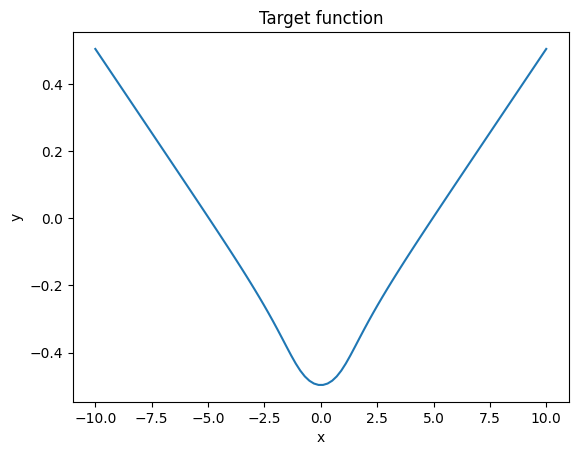

In [83]:
target_idx = 0
values_target = data_from_loader(train_loader, 'values', idx=target_idx)  
z_target = model.encoder(data_from_loader(train_loader, 'x', idx=target_idx))[0]

plt.plot(val_x.squeeze(), values_target.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [84]:
# Calculating z and y distances for all samples in training set

N = 2**19
BATCH_SIZE = 2**15
N = (min(len(train_loader.dataset), N) // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size

values = data_from_loader(train_loader, 'values', max_length=N)

z_dist = torch.empty(N, 3)
for i, x in tqdm(enumerate(data_from_loader(train_loader, 'x', batch_size=BATCH_SIZE, max_length=N)), total=N//BATCH_SIZE, desc='Calculating z distances'):
    mean, ln_var = model.encoder(x)

    l2_dist = torch.norm(mean - z_target, dim=1)
    cos_sim = F.cosine_similarity(mean, z_target)
    dot_prod = torch.sum(mean * z_target, dim=1)
    
    z_dist[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.stack([l2_dist, cos_sim, dot_prod], dim=1)

y_dist = torch.mean((values - values_target)**2, dim=1)  # MSE

Calculating z distances: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


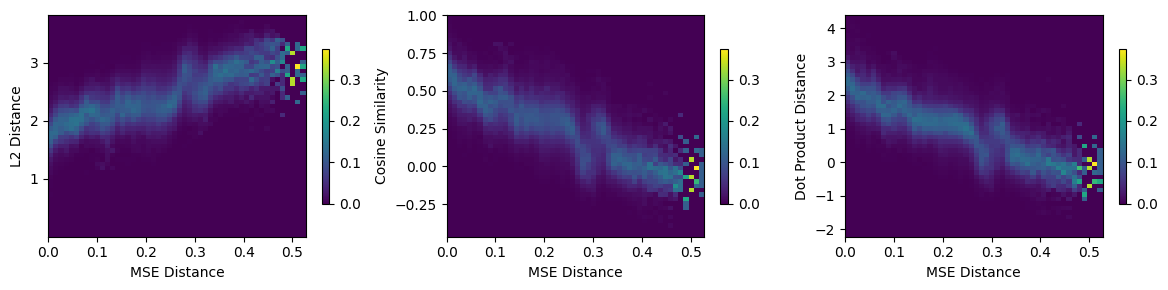

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# L2 Distance
h1, xedges, yedges, im1 = ax1.hist2d(y_dist.numpy(), z_dist[:, 0].numpy(), bins=50, cmap='viridis')
h1 = h1 / h1.sum(axis=1, keepdims=True)  # Normalize each column
im1.set_array(h1.T)
im1.set_clim(0, h1.max())  # Set colormap range from 0 to 1
plt.colorbar(im1, ax=ax1, shrink=0.7)
ax1.set_xlabel('MSE Distance')
ax1.set_ylabel('L2 Distance')

# Cosine Similarity 
h2, xedges, yedges, im2 = ax2.hist2d(y_dist.numpy(), z_dist[:, 1].numpy(), bins=50, cmap='viridis')
h2 = h2 / h2.sum(axis=1, keepdims=True)  # Normalize each column
im2.set_array(h2.T)
im2.set_clim(0, h2.max())  # Set colormap range from 0 to 1
plt.colorbar(im2, ax=ax2, shrink=0.7)
ax2.set_xlabel('MSE Distance')
ax2.set_ylabel('Cosine Similarity')

# Dot Product
h3, xedges, yedges, im3 = ax3.hist2d(y_dist.numpy(), z_dist[:, 2].numpy(), bins=50, cmap='viridis')
h3 = h3 / h3.sum(axis=1, keepdims=True)  # Normalize each column
im3.set_array(h3.T)
im3.set_clim(0, h3.max())  # Set colormap range from 0 to 1
plt.colorbar(im3, ax=ax3, shrink=0.7)
ax3.set_xlabel('MSE Distance')
ax3.set_ylabel('Dot Product Distance')

plt.tight_layout()

In [86]:
# Create plot that shows the sample eps used and the threshold used for y-dist

from ipywidgets import interactive, FloatLogSlider

dataset_size_ratio = N/len(train_loader.dataset)

def plot_hist2d(x_max, y_max, normalise):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
    
    # L2 Distance
    h1, xedges, yedges, im1 = ax1.hist2d(y_dist.numpy(), z_dist[:, 0].numpy(), 
                                        bins=50, 
                                        range=[(0, x_max), (0, y_max)], 
                                        cmap='viridis')
    total_samples = h1.sum()

    if normalise:
        norm = h1.sum(axis=1, keepdims=True)  # Normalize each column
        norm[norm == 0] = 1  # Avoid division by zero
        h1 = h1 / norm
    im1.set_array(h1.T)
    im1.set_clim(0, h1.max())  # Set colormap range from 0 to 1
    plt.colorbar(im1, ax=ax1, shrink=0.7)
    ax1.set_xlabel('MSE Distance (y)')
    ax1.set_ylabel('L2 Distance (z)')

    ax1.axvline(x=SIMILARITY_THRESHOLD, color='r', linestyle='--', label='Similarity threshold')
    ax1.axhline(y=model.sampling_eps, color='b', linestyle='--', label='Sampling eps')
    plt.legend()

    ax1.text(0.02, 0.98, f'Samples in FOV: {total_samples:.0f}\n (x{1/dataset_size_ratio:.1f} for dataset)', 
             transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()

interactive_plot = interactive(
    plot_hist2d,
    x_max=FloatLogSlider(min=-5, max=y_dist.max(), value=-1, description='MSE Range Max:'),
    y_max=FloatLogSlider(min=-1, max=1, value=0.48, description='L2 Range Max:'),
    normalise=widgets.Checkbox(value=False, description='Normalize columns')
)
display(interactive_plot)

interactive(children=(FloatLogSlider(value=1e-05, description='MSE Range Max:', max=0.5269352793693542, min=-5…

### 2.2 Find communities of similar expressions to target in latent space

In [92]:
similar_indices = np.where(y_dist < SIMILARITY_THRESHOLD)[0][:1000]  # Cap at 1000 samples

In [93]:
x_sim = torch.stack([data_from_loader(train_loader, 'x', idx=i) for i in similar_indices])
z_sim = model.encoder(x_sim)[0]

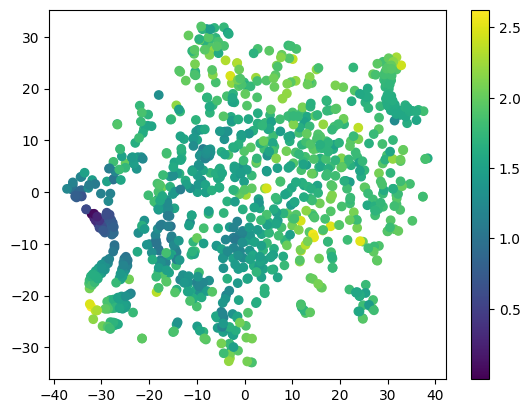

In [94]:
from sklearn.manifold import TSNE

# Run t-SNE to reduce dimensionality from 32D to 2D
tsne = TSNE(n_components=2, random_state=42)
z_sim_2d = tsne.fit_transform(z_sim.detach().numpy())

plt.scatter(z_sim_2d[:, 0], z_sim_2d[:, 1], c=z_dist[similar_indices, 0], cmap='viridis')
plt.colorbar()
plt.show()

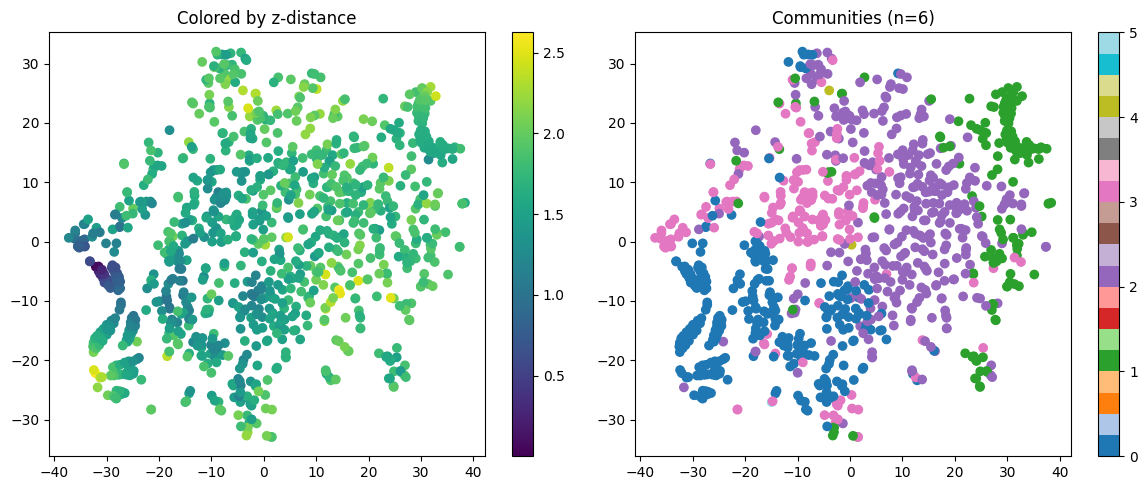

Number of communities detected: 6


In [96]:
# Run community detection using python-louvain (community)
import community.community_louvain as community_louvain
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances

# Calculate pairwise distances between latent vectors
distances = euclidean_distances(z_sim.detach().numpy())

# Convert distances to similarities (using negative exponential)
similarities = np.exp(-distances**2)

# Create networkx graph from similarity matrix
G = nx.from_numpy_array(similarities)

# Run Louvain community detection
communities_dict = community_louvain.best_partition(G)
communities = np.array([communities_dict[i] for i in range(len(G))])

# Plot the t-SNE embedding colored by communities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original plot with z-distances
scatter1 = ax1.scatter(z_sim_2d[:, 0], z_sim_2d[:, 1], c=z_dist[similar_indices, 0], cmap='viridis')
ax1.set_title('Colored by z-distance')
plt.colorbar(scatter1, ax=ax1)

# New plot with communities
scatter2 = ax2.scatter(z_sim_2d[:, 0], z_sim_2d[:, 1], c=communities, cmap='tab20')
ax2.set_title(f'Communities (n={len(np.unique(communities))})')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

print(f"Number of communities detected: {len(np.unique(communities))}")
